In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU') 
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [3]:
# from ZGlobalLib.gpu_utils import use_gpu
# use_gpu(0)

2024-02-12 10:42:49.851594: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 10:42:50.284385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [4]:
from HistoLib import generator
from HistoLib import utils
from HistoLib import models
from HistoLib import traintest

In [28]:
resolution = None
class_type = 'macro'
exclude_pd = True

assert resolution in ['20x', '40x', None] # TODO add also the public dataset
assert class_type in ['micro', 'macro']

## Get images

In [56]:
train_generator, val_generator, test_generator, class_names = generator.get_patient_generators(resolution, class_type, exclude_pd, batch_size=8)

Images (600x800)      Training: 252 | Validation: 131 | Test: 78  | Total: 461
Patients              Training: 17  | Validation: 8   | Test: 7   | Total: 32 
Class aca    (id 0)   Training: 83  | Validation: 59  | Test: 32  | Total: 174
Class nor    (id 1)   Training: 87  | Validation: 29  | Test: 26  | Total: 142
Class scc    (id 2)   Training: 82  | Validation: 43  | Test: 20  | Total: 145


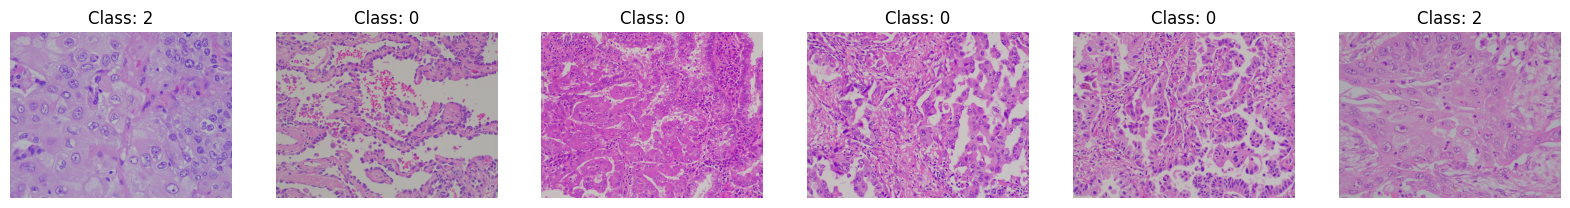

In [57]:
train_generator.show_generator()

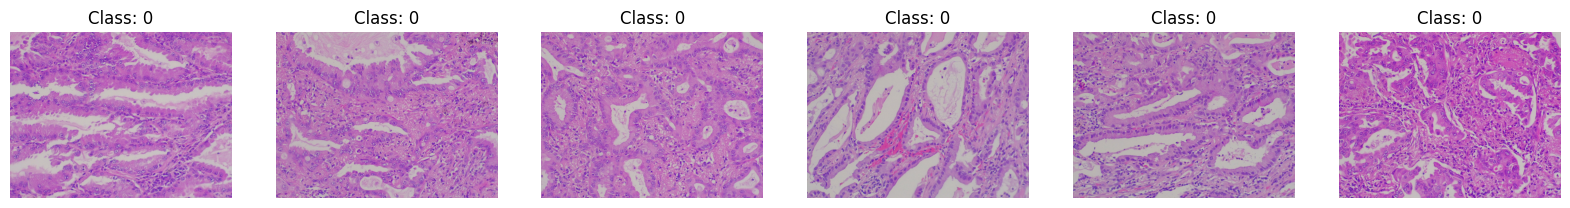

In [58]:
val_generator.show_generator()

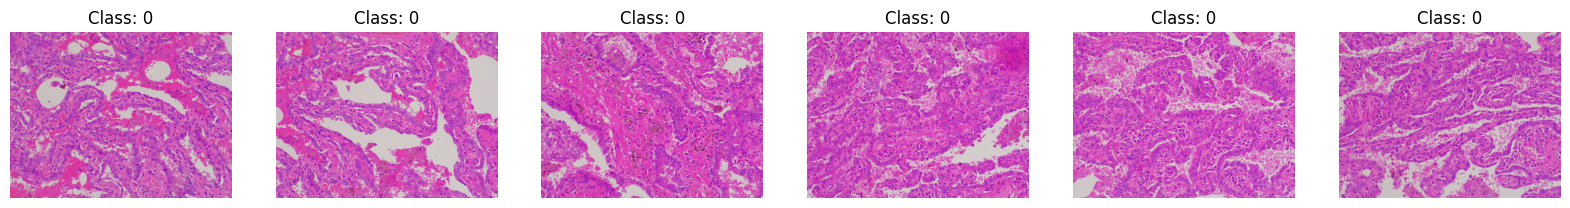

In [59]:
test_generator.show_generator()

In [60]:
class_weights = utils.compute_weights(train_generator)
class_weights

{0: 1.0120481927710843, 1: 0.9655172413793104, 2: 1.024390243902439}

## Train Model

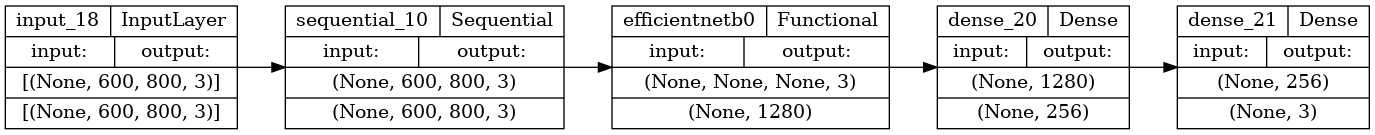

In [61]:
num_classes = len(class_weights)
model, model_name = models.get_model(train_generator, 'Eff0')

utils.plot_model(model)

In [43]:
log_dir = traintest.get_logdir(model_name)
log_dir

'logs/20240212-120118/EfficientNetB0'

In [44]:
# Train the model using the custom data generators and the debugging callback
model = traintest.compile_model(model, num_classes, init_lr=1e-5)
history = traintest.train_model(model, train_generator, val_generator, class_weights, log_dir)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Training interrupted. Stopping training...
Loading weights with best iteration...


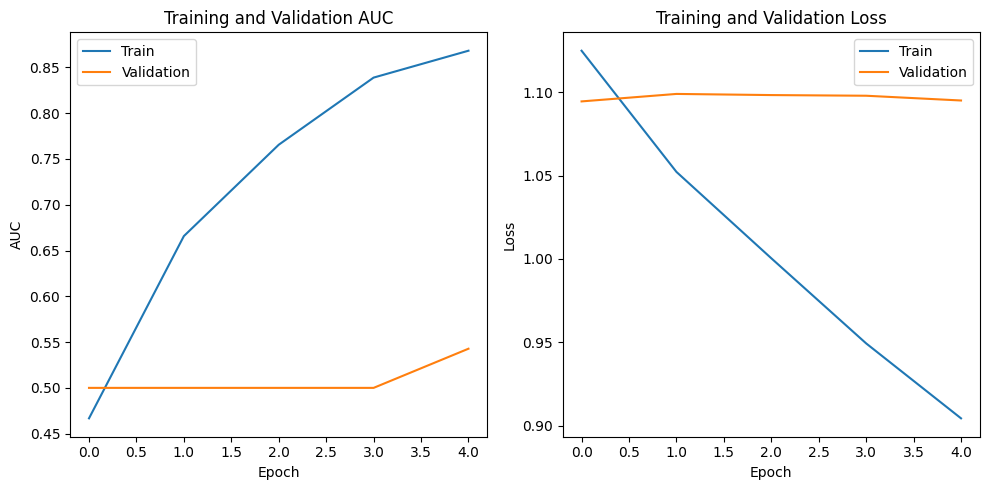

In [45]:
#Plot metrics
traintest.plot_metrics(history)

## Evaluate using test data

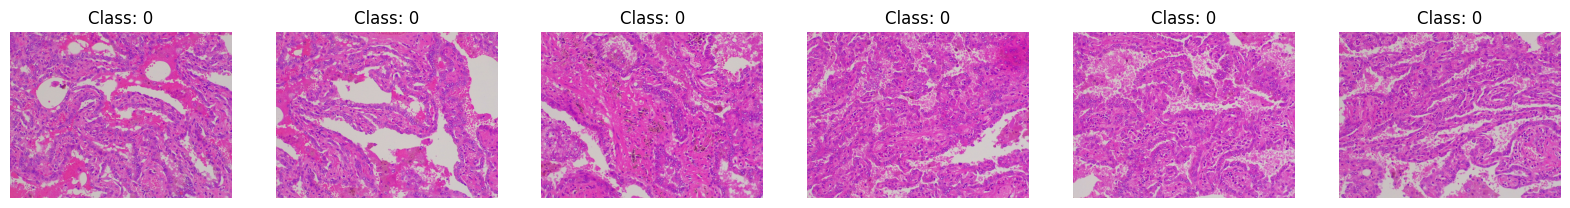

In [46]:
test_generator.show_generator()

Test Accuracy: 0.2564102564102564
Test Precision: 0.08547008547008546
Test Recall: 0.3333333333333333


/opt/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


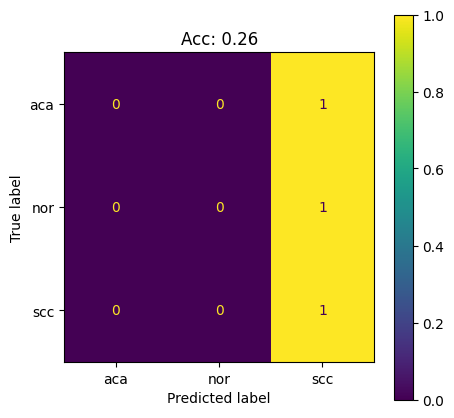

In [47]:
traintest.test_model(model, test_generator, class_names)

In [34]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [49]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)/255
    return array

In [52]:
val_generator.images[0]

'data/dataset_w_HC/scc_bd/scc_bd_20x_405.jpg'

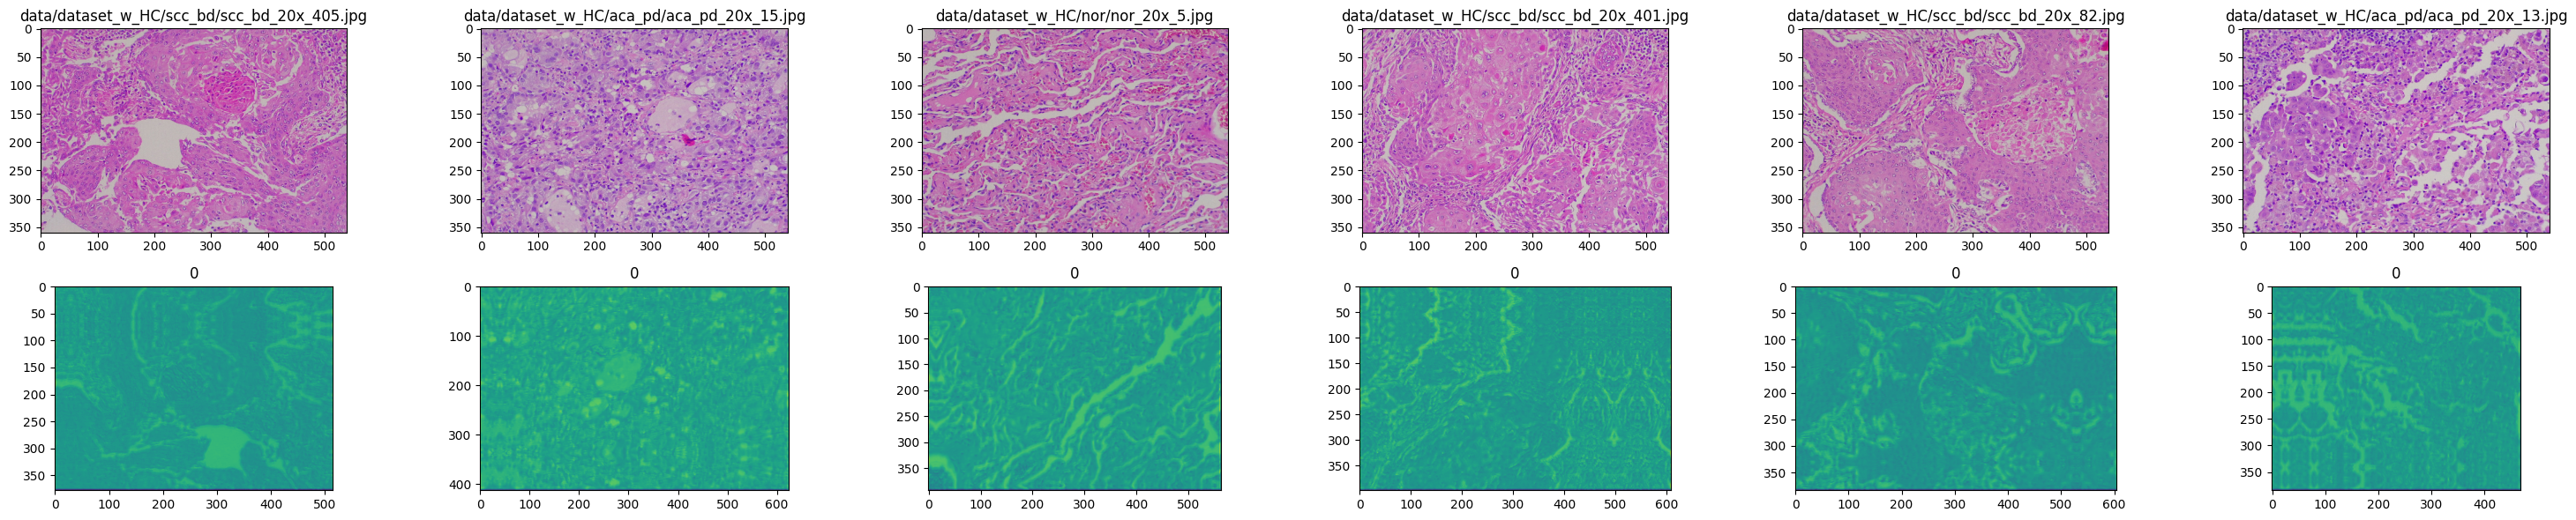

In [57]:
N = 6
fig, axs = plt.subplots(2,N, figsize=(30,6))
for i in range(N):    
    im = get_img_array(val_generator.images[i], (360, 540))
    axs[0,i].imshow(im[0]);
    axs[0,i].set_title(val_generator.images[i])
    heat = make_gradcam_heatmap(im, model, 'last_conv')
    axs[1,i].imshow(heat)
    axs[1,i].set_title(np.argmax(model.predict(im)[0]))
    
plt.tight_layout()
plt.show()